# The Cropland Data Layer Lecture Review
### Exploring US Crop Production


### Steps of the Analysis:
1. Read in shape files + raster files.
2. Clip files.
3. Describe Illinois land uses
4. Create crop rotation rasters.
5. Visualize rasters.
6. Merge in other data sources.

### The Import Line

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.signal import medfilt2d

## 1. Read in Data

Read them in:

### Where did you get the data??
Go to [this Box folder](https://uofi.app.box.com/s/5oflx70viho39izrqetdp2nnd44s2b3y) and go to the "Class Examples" Folder. **Careful**, do not download the whole folder, this will take WAY too long. Instead just download the "2_Images" folder

In [ ]:
# This directory below is where I have the data stored 
data_dir="C:/Users/brayd/OneDrive/Desktop/2_Images/"

In [ ]:
cd "C:\Users\brayd\OneDrive\Desktop\2_Images"

Rasters

In [ ]:
cdl_17 = rasterio.open(data_dir + "CDL_2017_clip.tif")
cdl_16 = rasterio.open(data_dir + "CDL_2016_clip.tif")

Shapefile

In [ ]:
country = geopandas.read_file(data_dir+"us_states.json")

Create a dictionary (just for FUN)

In [ ]:
cdls = {16:cdl_16,17:cdl_17}

### ahh, but did you remember to check the projection??

In [ ]:
#We would suspect that the crs for the two cdl layers to be the same but let's just double check 
cdl_17.crs==cdl_16.crs

### We are (unsurprisingly) good with the two cdl layers! 

In [ ]:
cdl_17.crs == country.crs

They are not the same! So easiest thing is just to reproject the vector file to the raster's CRS

In [ ]:
print(cdl_17.crs) 
print("__________________________")
print(country.crs)

In [ ]:
# Reproject
country = country.to_crs(cdl_16.crs)

In [ ]:
#Let's just double check the projections
cdl_17.crs == country.crs

In [ ]:
print(cdl_17.crs) 
print("__________________________")
print(country.crs)

## 2. Clipping Files

Want just Continental US

In [ ]:
country = country[(country.NAME!="Alaska")&\
                  (country.NAME!="Hawaii")&\
                  (country.NAME!="Puerto Rico")]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15));
rasterio.plot.show(cdl_16, ax=ax); #plots the cdl layers
plt.axis("off"); #This gets rid of the ugly axis surrounding the map 
country.plot(ax=ax, facecolor='none', edgecolor='black'); #plots the whole country

So we have a small window over Illinois, Indiana, Kentucky, and Ohio.

We just want Illinois, so we can do some clipping.

In [ ]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

### Let's break down this function to better understand it. (Which will kind of render the point of the function useless, but we need to understand what is going on! Let's not use a tool if we do not know what it is doing.)

In [ ]:
#What will we use as the gdf input if we just want Illinois?
country[(country["NAME"] == "Illinois")] #so 'gdf' in the function will take this output essentially

In [ ]:
#and it will create a json file from this, but remember json files are just dictionaries 
json.loads(country[(country["NAME"] == "Illinois")].to_json())#['features'][0]['geometry'] I commented out this last section 
#so we can see what happens when we uncomment it

In [ ]:
json.loads(country[(country["NAME"] == "Illinois")].to_json())['features'][0]#['geometry']

In [ ]:
json.loads(country[(country["NAME"] == "Illinois")].to_json())['features'][0]['geometry']

In [ ]:
IL_coords = getFeatures(country[(country["NAME"] == "Illinois")])

coords = \
{"IL": IL_coords}

img_out, img_transform = mask(cdl_16,IL_coords) #The mask will find the overlap where the IL shapefile 
#(from the country object) and the raster file (from cdl) overlap

In [ ]:
plt.imshow(img_out[0,:,:])

Gross! What is up with all of that extra space?? To save space, I'm actually going to cut off the right side of this raster

In [ ]:
#Remember images are just a collection of pixel values 
img_out[0,:,:] #but we have a lot of 0 values...

In [ ]:
img_out[:,:,:].shape

In [ ]:
img_out[0,:,:].shape

In [ ]:
plt.plot((img_out[0,:,:]!=0).sum(axis=0));

The non-zero pixels are basically to the left of 15k.

In [ ]:
plt.imshow(img_out[0,:,:15000])

Good enough.

There is, however, an easier way to do this... (__Hint: there's an argument I did not use__).

In [ ]:
#Function to change array information into raster info. with geographic info
#We want not just a bunch of pixels but a bunch of pixels with a location! 
#have to use the metadata to do this
for year,cdl in cdls.items():
    for k,v in coords.items():
        # Transform with the mask
        img_out, img_transform = mask(cdl,v) 
        
        # Cut out the right side of the image.
        img_out = img_out[:,:,:15000]
        
        # Metadata
        out_meta = cdl.meta.copy()
        out_meta['height'] = img_out.shape[1] #height
        out_meta['width'] = img_out.shape[2] #width
        out_meta['transform'] = img_transform
        
        # This field will tell you which pixel values mean "no data" and thus are transparent.
        out_meta['nodata'] = 0
        
        with rasterio.open("./raster_"+k+"_"+str(year)+".tif", "w", **out_meta) as dest:
            dest.write(img_out)

Now let's see if we did it right

In [ ]:
IL_16 = rasterio.open("./raster_IL_16.tif")

## Essentially, we took a raster file, edited as a numpy array, and then save it as a raster file  

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
rasterio.plot.show(IL_16, ax=ax)
country[country['NAME']=="Illinois"].plot(ax=ax, facecolor='none', edgecolor='black')

Things are missing from the edged because they are zero values, or "background" according to the CDL documentation/

## 3. Top 10 Land Uses in Each Year

To find the names for the pixels, I (the Professor, not the TA) made a dictionary (json file) from the CDL documentation. In your homework, you will want to create something similar.

In [ ]:
#this will likely cause an error on your computer because you do not have a CDL_dict. You will have to make one for your HW
with open("CDL_dict.json") as f:  
    pixel_names = json.load(f)[0]

Now we store all the rasters in one dictionary:

In [ ]:
rasters = {}
for year in cdls.keys():
    rasters[year] = {}
    for state in coords.keys():
        rasters[year][state] = rasterio.open("./raster_"+state+"_"+str(year)+".tif")

Let's have a quick reminder on what's in this function...

In [ ]:
cdls.keys()

In [ ]:
cdls

In [ ]:
coords.keys()

In [ ]:
coords

In [ ]:
state

In [ ]:
#The output dictionary! 
rasters

Let's look at one example:

In [ ]:
r17_array = rasters[17]['IL'].read(1)
pixels = pd.Series(r17_array.flatten())
pixels = pixels[pixels!=0]

pixel_counts = pixels.value_counts()
pixel_counts.head(10)

But what do these mean?

Here is where the dictionary comes in handy:

In [ ]:
#you will encounter an error here unless you have made a dictionary for the pixel values and names
# Extract the pixel labels
pixel_ixs = pd.Series(pixel_counts.index).astype(str)

# You can feed a dictionary to "replace"
pixel_counts.index = pixel_ixs.replace(pixel_names) #pixel_names is the dictionary of the values matched to the names

# Reindex the df
pixel_counts.head(10)

How much is that? Let's find the percentage.

In [ ]:
# Method 1:
(pixel_counts/pixel_counts.sum()*100).head(10)

Had I used the "normalize" argument, I could have done it when I called "value counts"

In [ ]:
#you will encounter an error here unless you have made a dictionary for the pixel values and names
# Method 2:
pixel_counts = pixels.value_counts(normalize=True)*100

pixel_ixs = pd.Series(pixel_counts.index).astype(str)

pixel_counts.index = pixel_ixs.replace(pixel_names)

pixel_counts.head(10)

So 31% of our land mass is corn, 27% forest, 15% forest, and the rest other things.

Visualizing with a pie chart is possible, but can be a bit awkward given how many labels there are:

In [ ]:
pixel_counts.plot(kind="pie")

Solutions?

Condense some of these categories:

In [ ]:
condensed_counts = pixel_counts.iloc[:4] #this takes the top 4 (index=0,1,2,3)
condensed_counts.loc["Other"] = pixel_counts.iloc[4:].sum() #this takes everything after and including the fourth index and sums
condensed_counts.plot(kind="pie")

We could also try and label things under the "Other" category better:

In [ ]:
# Which ixs have "developed" in the title?
Developed = ["Developed" in x for x in list(pixel_counts.index)] #creates Boolean

# Create a df with index as a column
pixel_counts_wix = pixel_counts.reset_index()

# Replace ixs with "developed" in them with just the label "Developed"
pixel_counts_wix.loc[Developed,"index"] = "Developed"

# Groupby each label, sum the pixels, and sort.
pixel_counts = pixel_counts_wix.groupby("index").sum()[0].sort_values(ascending=False)

In [ ]:
condensed_counts = pixel_counts.iloc[:5]
condensed_counts.loc["Other"] = pixel_counts.iloc[4:].sum()
condensed_counts.plot(kind="pie", autopct='%1.1f%%')

## 4. Making Crop Rasters

Here I (the Professor, not the TA) wrote a function that does the write and transform tasks necessary to transform and array into a raster.

End goal, is to understand how people are rotating corn and soybeans in the state of IL. We also, want to produce some statistics 

In [ ]:
def recode_raster_binary(raster,array,img_transform,name):
    out_meta = raster.meta.copy()
    array = array[np.newaxis,:,:] #rasters have a third dimension
    out_meta['height'] = array.shape[1]
    out_meta['width'] = array.shape[2]
    out_meta['transform'] = img_transform
    
    with rasterio.open(name, "w", **out_meta) as dest:
        dest.write(array.astype(rasterio.uint8)) # Notice here it codes "uint8" because thats all we need for binary data

Using the documentation, we know that these are the two codes for corn and soybeans:

In [ ]:
crop_labels = {1:"corn",5:"soybeans"}

Below is a nested for loop that creates a nested dictionary with these rasters:

In [ ]:
crop_rasters = {}

# For each state
for state in coords.keys():
    crop_rasters[state] = {}
    # For each CDL year:
    for year in cdls.keys():
        crop_rasters[state][year] = {}
        # For each crop:
        for val,crop in crop_labels.items():
            # Read in the band and make a binary array:
            array = (rasters[year][state].read(1)==val).astype(np.int8)
            
            # Write it out using our function
            recode_raster_binary(cdl,array,img_transform,"./raster_"+state+"_"+str(year)+"_"+crop+".tif")

            # Store it in this dictionary:
            crop_rasters[state][year][crop] = rasterio.open("./raster_"+state+"_"+str(year)+"_"+crop+".tif")

## Example
Remember, we are just looking a pixels and their values.

Let's talk about what the above code did:

We are going to look at an example on a phony piece of data that I made up so we can talk through the code. Imagine we are looking at a small piece of land represented by the cells below. Each cell is a pixel and normally, they have numeric values, but for this example, I will just code it as letters. 

C=Corn, S=Soybean, X=other (we are not interested)

So this is what we start with:

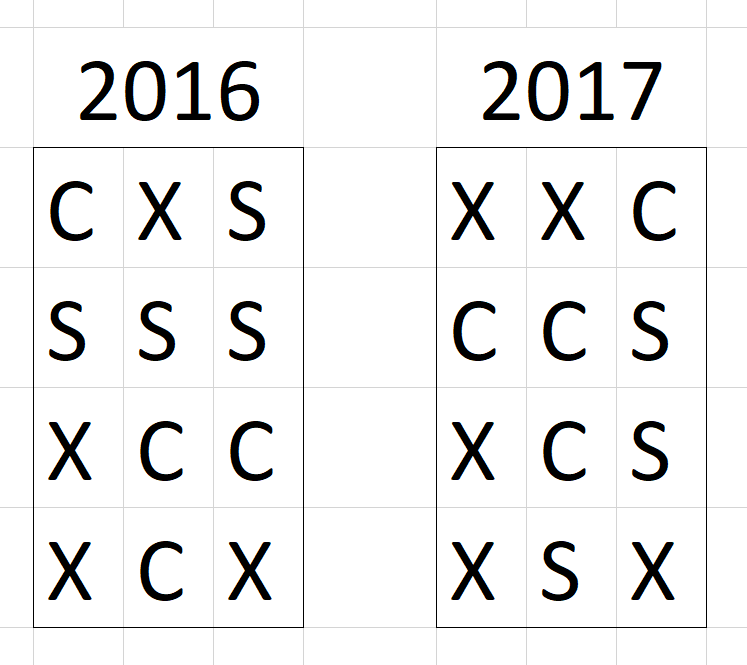

We then, go by year and crop type that we are interested in and code it as 1 or 0 

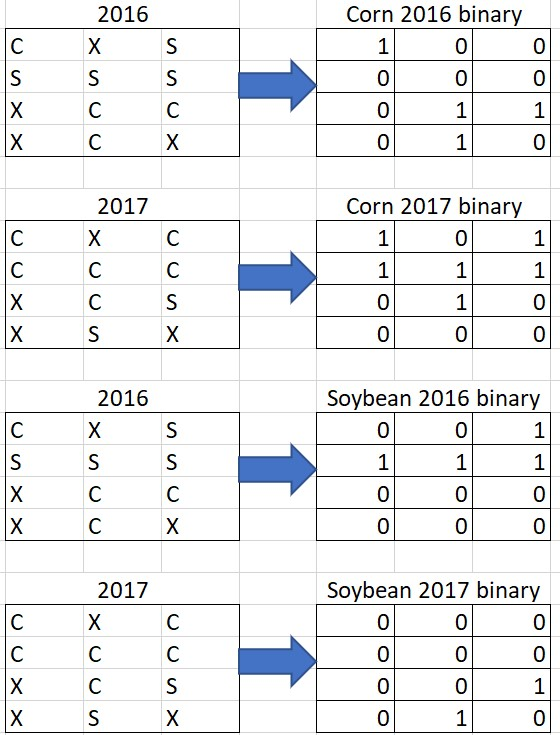

And this is what we plot below!

Now plot it:

In [ ]:
# Make some colormaps first: 

cmap_beans = matplotlib.colors.ListedColormap(['white','mediumblue'])
cmap_corn = matplotlib.colors.ListedColormap(['white','darkorange'])

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10, 15))

# Corn 2016
rasterio.plot.show(crop_rasters["IL"][16]["corn"], ax=ax[0,0],cmap=cmap_corn)
ax[0,0].set_title("Corn Area, 2016")
country[country['NAME']=="Illinois"].plot(ax=ax[0,0], facecolor='none', edgecolor='black')

# Soybeans 2016
rasterio.plot.show(crop_rasters["IL"][16]["soybeans"], ax=ax[0,1],cmap=cmap_beans)
ax[0,1].set_title("Soybean Area, 2016")
country[country['NAME']=="Illinois"].plot(ax=ax[0,1], facecolor='none', edgecolor='black')

# Corn 2017
rasterio.plot.show(crop_rasters["IL"][17]["corn"], ax=ax[1,0],cmap=cmap_corn)
ax[1,0].set_title("Corn Area, 2017")
country[country['NAME']=="Illinois"].plot(ax=ax[1,0], facecolor='none', edgecolor='black')

# Soybeans 2017
rasterio.plot.show(crop_rasters["IL"][17]["soybeans"], ax=ax[1,1],cmap=cmap_beans)
ax[1,1].set_title("Soybean Area, 2017")
country[country['NAME']=="Illinois"].plot(ax=ax[1,1], facecolor='none', edgecolor='black')

### How do we determine crop rotation?

What we want to know is how often a pixel changed from being a 1 to a 5 and vice versa, and also how often did it stay the same.

There are two ways to do this. One is the REALLY LONG way: go through each index and assign a 1 or a 2 to anything monocropped or rotated.

What's the __vectorized__ way?

Since we are comparing pixels in the same location but in different years, we can do an element by element comparison. Is the pixel corn in one year and corn the next? Is the pixel soybeans in one year and corn the next? etc.

In [ ]:
# Its very useful to make matrices like this that are three dimensions.
# Each line here reads raster, gives it a new first axis
# The outer code concatenates them on the new first axis to make them 3D arrays.
IL_17 = np.concatenate([rasterio.open("./raster_IL_17_corn.tif").read(1)[np.newaxis,:,:], 
                        rasterio.open("./raster_IL_17_soybeans.tif").read(1)[np.newaxis,:,:]],axis=0) 

IL_16 = np.concatenate([rasterio.open("./raster_IL_16_corn.tif").read(1)[np.newaxis,:,:],
                        rasterio.open("./raster_IL_16_soybeans.tif").read(1)[np.newaxis,:,:]],axis=0)

Here I'm going to assess a boolean condition about the rasters, multiplying them by the number I want them to be.

In [ ]:
# Assign a one to anything monocropped
corn_to_corn = ((IL_17[0,:,:]==1)&(IL_16[0,:,:]==1))*1 #The first indice (index=0) is corn. IL_16[0,:,:] That's what the 0 means
beans_to_beans = ((IL_17[1,:,:]==1)&(IL_16[1,:,:]==1))*1 #The second (index=1) is soybean.  IL_16[1,:,:] That's what the 1 means

# Assign a two to anything that rotated
beans_to_corn = ((IL_17[0,:,:]==1)&(IL_16[1,:,:]==1))*2
corn_to_beans = ((IL_17[1,:,:]==1)&(IL_16[0,:,:]==1))*2

## Let's visualize this!
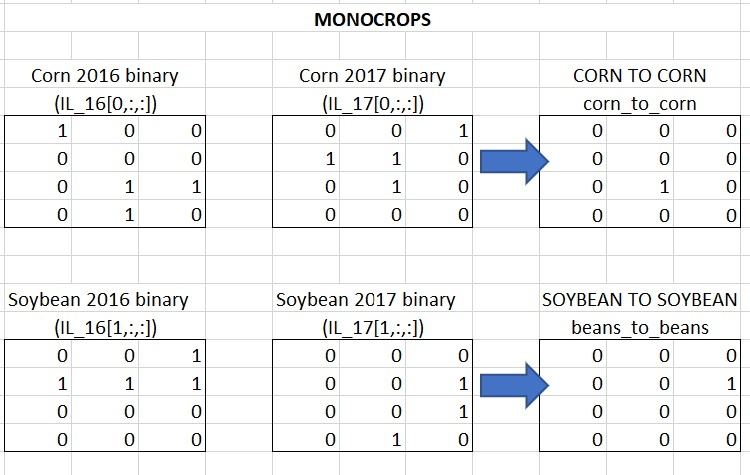

Unlike before, note that for rotated crops we now have a value of 2 not 1 in the output. This is so we can distinguish roated from not
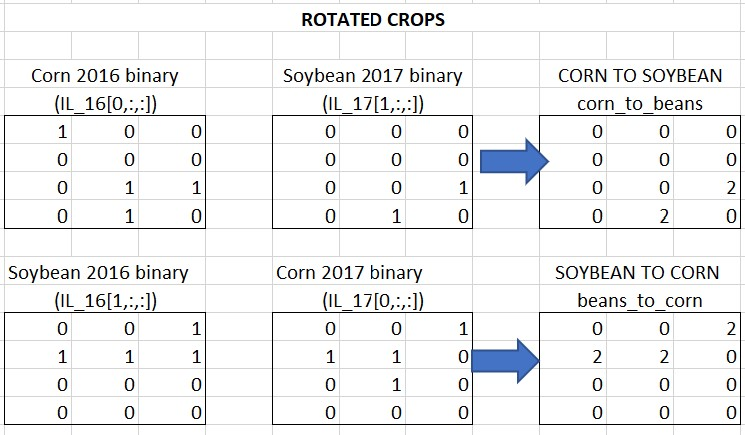

Assuming all these categories are mutually exclusive, we can just add them all together:

In [ ]:
Rotated = corn_to_corn + beans_to_beans + beans_to_corn + corn_to_beans 

In [ ]:
Rotated[Rotated!=0]

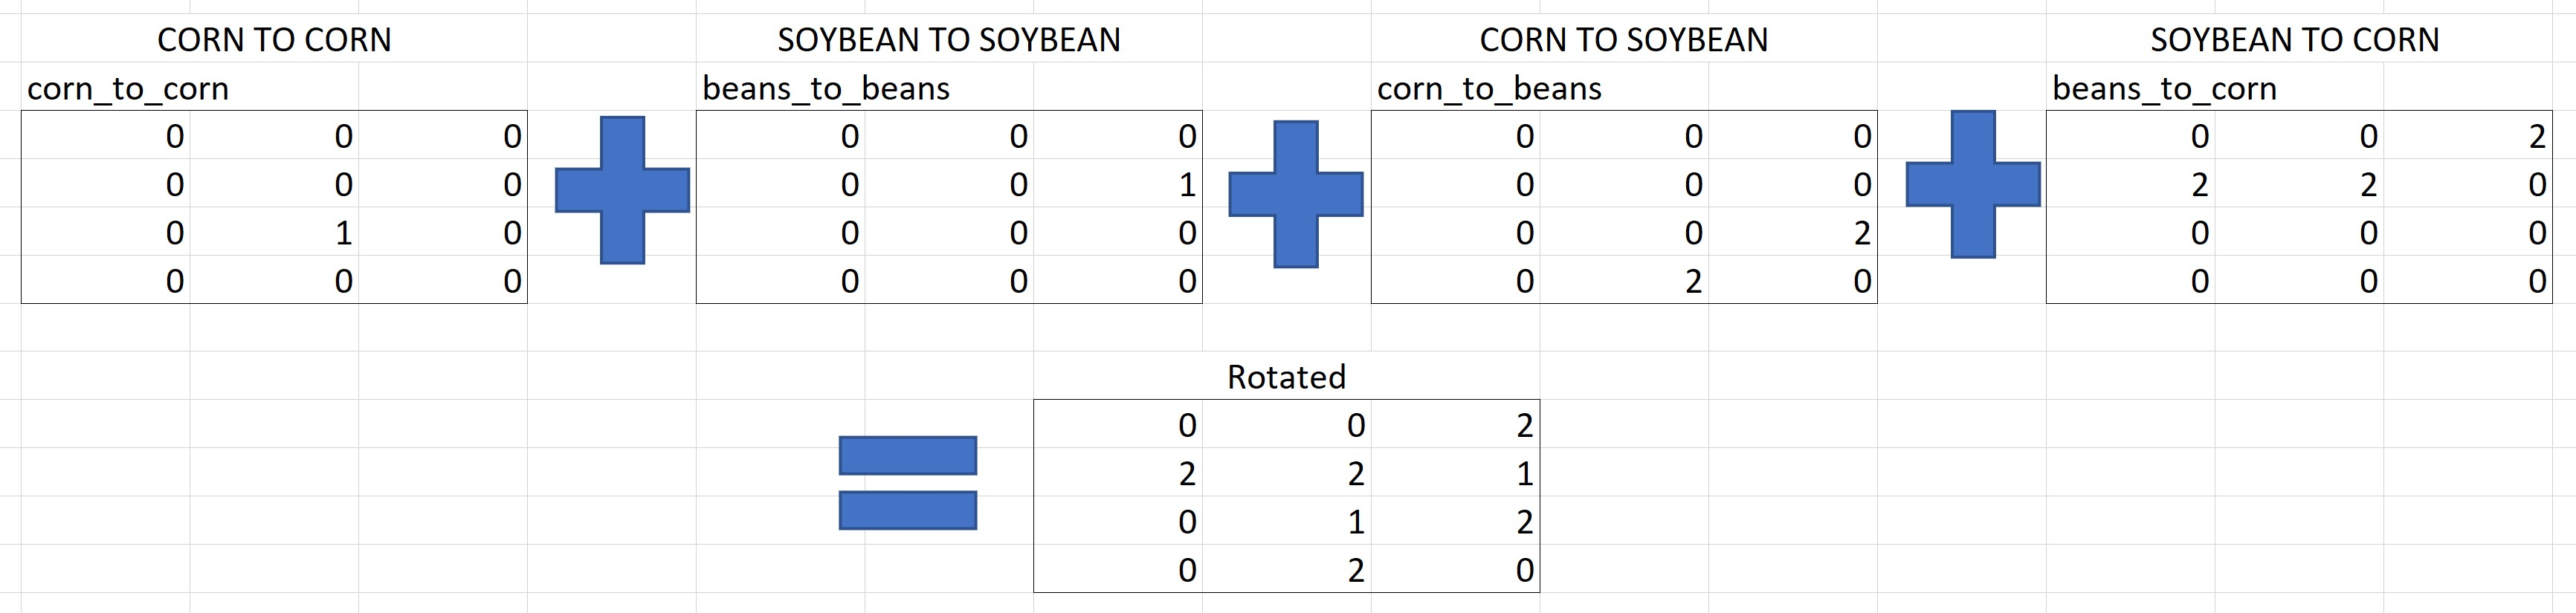

Everything not in those categories will be zero.

So what percent of the pixels were rotated between corn and soybeans?

In [ ]:
rotated_pixels = pd.Series(Rotated.flatten())

rotated_pixels[rotated_pixels!=0].value_counts(normalize=True)*100

Nearly 80% of soybeans and corn is rotated between the two.

Visualizing what we just created:

In [ ]:
# First put it in a raster format by using function previously defined:
recode_raster_binary(cdl_16,Rotated,img_transform,"./raster_IL_rotation.tif")

Rotated_Raster = rasterio.open("./raster_IL_rotation.tif")

Next make a colormap:

In [ ]:
labels = {1:"Non-Rotated",
          2:"Rotated"}

cmap = matplotlib.colors.ListedColormap(['white', "C3","C0"])

patches =[mpatches.Patch(color=cmap(i),label=labels[i]) for i in labels.keys()]

Now plot them together

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(Rotated_Raster,cmap=cmap,ax=ax)
country[country['NAME']=="Illinois"].plot(ax=ax, facecolor='none', edgecolor='black')
plt.legend(handles=patches,fontsize=16)
plt.axis('off')

### What about the different types of rotation?

In [ ]:
#What we are doing here, is analogous to what we did before but we assign a unique value to each kind of ratation 
# As before:
corn_to_corn = ((IL_17[0,:,:]==1)&(IL_16[0,:,:]==1))*1
beans_to_beans = ((IL_17[1,:,:]==1)&(IL_16[1,:,:]==1))*2
beans_to_corn = ((IL_17[0,:,:]==1)&(IL_16[1,:,:]==1))*3
corn_to_beans = ((IL_17[1,:,:]==1)&(IL_16[0,:,:]==1))*4

In [ ]:
Rotated_Cats = corn_to_corn + beans_to_beans + beans_to_corn + corn_to_beans

__FYI: the long, for loop way would be:__

In [ ]:
# DO NOT RUN THIS UNLESS YOU WANT IT TO TAKE AWHILE  
#for i in range(Rotation.shape[0]):
#     for j in range(Rotation.shape[1]):
#         if (IL_17[0,i,j]==1)&(IL_16[0,i,j]==1):
#             Rotation[i,j] = 1
#         elif (IL_17[1,i,j]==1)&(IL_16[1,i,j]==1):
#             Rotation[i,j] = 2
#         elif (IL_17[0,i,j]==1)&(IL_16[1,i,j]==1):
#             Rotation[i,j] = 3
#         elif (IL_17[1,i,j]==1)&(IL_16[0,i,j]==1):
#             Rotation[i,j] = 4

__Don't run this code unless you want your computer to busy for days.__

Writing out the array in a raster format:

In [ ]:
recode_raster_binary(cdl_16,Rotated_Cats,img_transform,"./raster_IL_rotation_cats.tif")

Rotated_Cat_Raster = rasterio.open("./raster_IL_rotation_cats.tif")

## 5. Visualizing the Crop Rotation Raster

In [ ]:
cmap = matplotlib.colors.ListedColormap(['white',"gold","mediumseagreen", 'mediumblue','darkorange'])

labels = {1:"Corn to Corn",
          2:"Beans to Beans",
          3:"Beans to Corn",
          4:"Corn to Beans"}

patches =[mpatches.Patch(color=cmap(i),label=labels[i]) for i in labels.keys()] #just a way to incorporate colors and 
#labels in matplotlib 

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
rasterio.plot.show(Rotated_Cat_Raster,cmap=cmap,ax=ax)
country[country['NAME']=="Illinois"].plot(ax=ax, facecolor='none', edgecolor='black')
plt.legend(handles=patches,fontsize=12,loc=(0,.8))
plt.axis('off')

In table form:

In [ ]:
Rotated_Series = pd.Series(Rotated_Cats.flatten())

top_transitions = Rotated_Series[Rotated_Series!=0].value_counts(normalize=True)*100

labels = {"1":"Corn to Corn",
          "2":"Beans to Beans",
          "3":"Beans to Corn",
          "4":"Corn to Beans"}

top_transitions.index = pd.Series(top_transitions.index).astype(str).replace(labels)

top_transitions

Not surprisingly, crop rotation is equally split between corn and beans (nearly). About 20\% of pixels did not rotate, mostly in the North or South of the state.